---
title: LAB 6 Baseball Players
author: Alexa Dandridge
format:
    html:
        embed-resources: true
        code-line numbers: true

---
**GitHub Repository** <https://github.com/alexadandridge/Positron-Class-Week-0->

In [135]:
# Importing necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

In [136]:
# Setting the working directory
os.chdir("/Users/alexad/Desktop/Positron Class Week 0")
# Reading in the excel file
myData = pd.read_csv('Hitters.csv')
myData.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [137]:
# Cleaning the data

# Get rid of columns with mostly NaN values
good_cols = myData.isna().sum() < 100
myData = myData.loc[:,good_cols]

# Drop other NAs
myData = myData.dropna()

# **PART I: Different Model Specs**

## ***A. Regression without regularization***

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression

2. Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

3. Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [138]:
# Defining X and y; X is all columns other than target, Salary
X = myData.drop(["Salary"], axis = 1)
y = myData["Salary"]

In [139]:
myData.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [140]:
# Making the Column Transformer for model 1: linear regression
MODELlrct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'), ["League", "Division", "NewLeague"]), #step one- applying to categorical variables
    ("standardize", StandardScaler(), ["AtBat", "Hits", "HmRun", "Runs", "RBI", "Walks", "Years", "CAtBat", "CHits", "CHmRun", "CRuns", "CRBI", "CWalks", "PutOuts", "Assists", "Errors"]) #step two- standardizing numerical variables
  ],
  remainder = "drop" # allows us to select which variables we want to use (we are using all variables, excpet salary in this case)
)

In [141]:
# Making the Pipeline for model 1: linear regression
MODELlr_pipeline = Pipeline(
  [("preprocessing", MODELlrct),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

In [142]:
# Fitting the training data on Model 1 pipeline
MODELlr_fitted = MODELlr_pipeline.fit(X, y)

In [143]:
# Seeing coefficients and intercept for this model
MODELlr_fitted.named_steps['linear_regression'].coef_, MODELlr_fitted.named_steps['linear_regression'].intercept_

(array([ -31.29971152,   31.29971152,   58.42462282,  -58.42462282,   12.38116255,
         -12.38116255, -291.0945557 ,  337.83047948,   37.85383676,  -60.57247861,
         -26.99498379,  135.07389695,  -16.69335888, -391.03865466,   86.68761664,
         -14.18172332,  480.74713477,  260.68988581, -213.89225864,   78.76129639,
          53.73248973,  -22.16086217]),
 np.float64(537.9273144423057))

**Interpretation:**

The coefficients represent the estamated change in Salary for a one unit increase in each predictor, while holding others constant and standardizing. The intercept shows the baseline salary when all other predictors are standardized and at 0 (so basically at their mean levels).

The largest negative coefficient is -391.03865 for CWalks (career walks), which means career walks has a negative relationship with salary. If all else constant, an increase of one standard deviation in career walks is associated with a $391K lower predicted salary. 

The largest positive coefficient is 480.7471 for CHmRun (career home runs), which means that a one standard deviation increase in CHmRun is associated with about a $480K increase in predicted salary.

The first two coefficients are -31.2997 and 31.2997, which address the dummay variables for League A and League N. One league tends to have salaries that are about $31K lower than those in the other league. 

The intercept, 537.9273, shows that a player with average performance stats, and baseline categories in the dummy variables, is predicted to earn about $537K.

In [144]:
# Using cross-validation to estimate the MSE
MODELlrscores = cross_val_score(MODELlr_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
MODELlrscores

array([ -76408.91409134, -129937.76968228,  -79976.48830477, -204818.01839674,
       -114540.36111572])

In [145]:
MODELlrmeanscore = -np.mean(MODELlrscores)
MODELlrmeanscore

np.float64(121136.31031816888)

**Estimated MSE:** The estimated mean squared error (MSE) is 121136.31.

## ***B. Ridge regression***

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to tune the lambda
 hyperparameter.

3. Fit the pipeline with your chosen lambda
 to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [146]:
# Defining X and y; X is all columns other than target, Salary
X = myData.drop(["Salary"], axis = 1)
y = myData["Salary"]

In [147]:
# Making the Column Transformer for model 2: ridge regression
MODELridgect = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'), ["League", "Division", "NewLeague"]), #step one- applying to categorical variables
    ("standardize", StandardScaler(), ["AtBat", "Hits", "HmRun", "Runs", "RBI", "Walks", "Years", "CAtBat", "CHits", "CHmRun", "CRuns", "CRBI", "CWalks", "PutOuts", "Assists", "Errors"]) #step two- standardizing numerical variables
  ],
  remainder = "drop" # allows us to select which variables we want to use (we are using all variables, excpet salary in this case)
)

In [148]:
#making ridge pipeline
ridge_pipeline = Pipeline(
  [("preprocessing", MODELridgect),
  ("ridge_regression", Ridge(alpha=1))]
)

In [149]:
# using gridsearchcv to perform tuning on the pipeline
from sklearn.model_selection import GridSearchCV

ridge_pipeline = Pipeline(
  [("preprocessing", MODELridgect),
  ("ridge_regression", Ridge())]
).set_output(transform="pandas")
# name of step, double underscore, name of parameter
alphas = {'ridge_regression__alpha': np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])}   # thinking of a log scale/ order of magnitude rather than trying just 1, 2, 3...

gscv = GridSearchCV(ridge_pipeline, param_grid=alphas, cv = 5, scoring='r2')

In [150]:
# fitting model onto the data
gscv_fitted = gscv.fit(X, y)

gscv_fitted.cv_results_

{'mean_fit_time': array([0.00863676, 0.00438256, 0.00409594, 0.0059092 , 0.00408878, 0.00317917,
        0.00302153]),
 'std_fit_time': array([0.00483736, 0.00089184, 0.00097267, 0.00272126, 0.00110814, 0.00018486,
        0.00012896]),
 'mean_score_time': array([0.00664725, 0.00322576, 0.00246   , 0.00331602, 0.00209537, 0.00203071,
        0.00205684]),
 'std_score_time': array([5.57708528e-03, 8.45141966e-04, 3.94105406e-04, 7.40274670e-04, 4.29967532e-05,
        1.04165686e-04, 1.59088412e-04]),
 'param_ridge_regression__alpha': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
              mask=[False, False, False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'ridge_regression__alpha': np.float64(0.001)},
  {'ridge_regression__alpha': np.float64(0.01)},
  {'ridge_regression__alpha': np.float64(0.1)},
  {'ridge_regression__alpha': np.float64(1.0)},
  {'ridge_regression__alpha': np.float64(10.0)},
  {'ridge_regression__alpha': np.float64(100.

In [151]:
# showing the results neatly
df_cv_results_ = pd.DataFrame(gscv_fitted.cv_results_)

df_cv_results_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge_regression__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008637,0.004837,0.006647,0.005577,0.001,{'ridge_regression__alpha': 0.001},0.299696,0.570873,0.644824,-0.018916,0.221304,0.343556,0.241118,6
1,0.004383,0.000892,0.003226,0.000845,0.010,{'ridge_regression__alpha': 0.01},0.299530,0.570901,0.644947,-0.017067,0.222109,0.344084,0.240523,5
2,0.004096,0.000973,0.002460,0.000394,0.100,{'ridge_regression__alpha': 0.1},0.298033,0.570619,0.646043,-0.004872,0.228550,0.347675,0.236505,4
3,0.005909,0.002721,0.003316,0.000740,1.000,{'ridge_regression__alpha': 1.0},0.295380,0.559025,0.652602,0.018084,0.253745,0.355767,0.226940,3
4,0.004089,0.001108,0.002095,0.000043,10.000,{'ridge_regression__alpha': 10.0},0.369375,0.506080,0.647370,0.040405,0.278407,0.368328,0.206136,2
5,0.003179,0.000185,0.002031,0.000104,100.000,{'ridge_regression__alpha': 100.0},0.503192,0.441811,0.579676,0.063923,0.336460,0.385012,0.179188,1
6,0.003022,0.000129,0.002057,0.000159,1000.000,{'ridge_regression__alpha': 1000.0},0.507480,0.303704,0.398499,0.125636,0.329270,0.332918,0.125384,7


After using cross-validation to tune the parameter, we see that the value of 100 creates teh best model. We will use the value of 100 for the parameter moving forward with this ridge regression.

In [152]:
#making ridge pipeline with the parameter of 100
NEWridge_pipeline = Pipeline(
  [("preprocessing", MODELridgect),
  ("ridge_regression", Ridge(alpha=100))]
)

In [153]:
#fitting the data on the ridge pipeline
NEWridge_pipeline_fitted = NEWridge_pipeline.fit(X, y)

NEWridge_pipeline_fitted

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['League', 'Division',
                                                   'NewLeague']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  ['AtBat', 'Hits', 'HmRun',
                                                   'Runs', 'RBI', 'Walks',
                                                   'Years', 'CAtBat', 'CHits',
                                                   'CHmRun', 'CRuns', 'CRBI',
                                                   'CWalks', 'PutOuts',
                                                   'Assists', 'Errors'])])),
                ('ridge_regression', Ridge(alpha=100))])

In [154]:
# Seeing coefficients and intercept for this model
NEWridge_pipeline_fitted.named_steps['ridge_regression'].coef_, NEWridge_pipeline_fitted.named_steps['ridge_regression'].intercept_

(array([-11.05184162,  11.05184162,  38.02322237, -38.02322237,  -4.09159035,
          4.09159035,  -0.56737013,  49.6123856 ,  -1.4641586 ,  29.34326268,
         22.95801548,  41.38461684,  -2.7083058 ,  24.70584373,  44.53427648,
         38.6853297 ,  45.5076061 ,  47.1455561 ,   4.03637066,  56.88152161,
          7.45723865, -13.38238979]),
 np.float64(537.5746804284508))

**Interpretation:** 

After using the ridge regression model, which helps add a penalty, we see that the highest coefficient is 56.8815 for PutOuts, which shows that players with more putouts tend to earn higher salaries. 

We see that 47.1456 for CRBI is the second highest coefficient, and it shows that players who have more career RBI's usually have a higher salary.

The coefficient for Cruns is 45.5076 which indicated that with more runs, the higher the salary. 

Each of these coefficients demonstrate the impact on salary when all other factors are constant and the predictor is increased by one unit. 

In [155]:
# Using cross-validation to estimate the MSE
MODELridgescores = cross_val_score(NEWridge_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
MODELridgescores

array([ -54207.32108578, -169015.66198054,  -94642.61915686, -188126.211999  ,
        -97590.3637247 ])

In [156]:
MODELridgemeanscore = -np.mean(MODELridgescores)
MODELridgemeanscore

np.float64(120716.43558937623)

**Estimated MSE:** The estimated mean squared error (MSE) is 120716.4356.

## ***C. LASSO regression***

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary lasso regression

2. Use cross-validation to tune the lambda
 hyperparameter.

3. Fit the pipeline with your chosen lambda
 to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [157]:
# Defining X and y; X is all columns other than target, Salary
X = myData.drop(["Salary"], axis = 1)
y = myData["Salary"]

In [158]:
# Making the Column Transformer for model 3: lasso regression
MODELlassoct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'), ["League", "Division", "NewLeague"]), #step one- applying to categorical variables
    ("standardize", StandardScaler(), ["AtBat", "Hits", "HmRun", "Runs", "RBI", "Walks", "Years", "CAtBat", "CHits", "CHmRun", "CRuns", "CRBI", "CWalks", "PutOuts", "Assists", "Errors"]) #step two- standardizing numerical variables
  ],
  remainder = "drop" # allows us to select which variables we want to use (we are using all variables, excpet salary in this case)
)

In [159]:
# creating a lasso pipeline and tuning the parameter
lasso_pipeline = Pipeline(
  [("preprocessing", MODELlassoct),
  ("lasso_regression", Lasso())]
).set_output(transform="pandas")

alphas = {'lasso_regression__alpha': np.array([1000, 100, 10, 1, 0.1, 0.01])}

gscv = GridSearchCV(lasso_pipeline, param_grid=alphas, cv = 5, scoring='r2')

In [160]:
# fitting on to the data
gscv_fitted = gscv.fit(X, y)

gscv_fitted.cv_results_

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.815e+03, tolerance: 4.281e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.923e+04, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.726e+05, toler

{'mean_fit_time': array([0.00447183, 0.0031064 , 0.0033308 , 0.00585451, 0.0084331 , 0.06332259]),
 'std_fit_time': array([2.78740095e-03, 9.04355833e-05, 1.33557960e-04, 1.89912675e-03, 5.17251141e-03,
        2.57180382e-02]),
 'mean_score_time': array([0.00210299, 0.0020678 , 0.0019362 , 0.00197821, 0.0057476 , 0.01824121]),
 'std_score_time': array([1.92230417e-04, 1.65942277e-04, 2.27486810e-05, 3.80940070e-05, 7.33901181e-03,
        1.49621233e-02]),
 'param_lasso_regression__alpha': masked_array(data=[1000.0, 100.0, 10.0, 1.0, 0.1, 0.01],
              mask=[False, False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'lasso_regression__alpha': np.float64(1000.0)},
  {'lasso_regression__alpha': np.float64(100.0)},
  {'lasso_regression__alpha': np.float64(10.0)},
  {'lasso_regression__alpha': np.float64(1.0)},
  {'lasso_regression__alpha': np.float64(0.1)},
  {'lasso_regression__alpha': np.float64(0.01)}],
 'split0_test_score': array([-0.09969416,  0.496518

In [161]:
# Neatly showing the results
df_cv_results_ = pd.DataFrame(gscv_fitted.cv_results_)

df_cv_results_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso_regression__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004472,0.002787,0.002103,0.000192,1000.00,{'lasso_regression__alpha': 1000.0},-0.099694,-0.094347,-0.001156,-0.006478,-0.014349,-0.043205,0.044173,6
1,0.003106,0.000090,0.002068,0.000166,100.00,{'lasso_regression__alpha': 100.0},0.496518,0.214289,0.346721,0.098794,0.335587,0.298382,0.134079,5
2,0.003331,0.000134,0.001936,0.000023,10.00,{'lasso_regression__alpha': 10.0},0.448719,0.462930,0.603153,0.038731,0.294080,0.369523,0.192195,1
3,0.005855,0.001899,0.001978,0.000038,1.00,{'lasso_regression__alpha': 1.0},0.307016,0.554011,0.648122,0.010867,0.251175,0.354238,0.226730,2
4,0.008433,0.005173,0.005748,0.007339,0.10,{'lasso_regression__alpha': 0.1},0.300224,0.571645,0.645687,-0.014896,0.227544,0.346041,0.239625,3
5,0.063323,0.025718,0.018241,0.014962,0.01,{'lasso_regression__alpha': 0.01},0.300251,0.572060,0.644800,-0.018534,0.223396,0.344394,0.240990,4


In [162]:
# chose the best model (alpha = 10)
NEWlasso_pipeline = Pipeline(
  [("preprocessing", MODELlassoct),
  ("lasso_regression", Lasso(alpha=10))]      #changed ridge to lasso (everything else is the same)
)

In [163]:
# fitting data to the best model
lasso_pipeline_fitted = NEWlasso_pipeline.fit(X, y)

lasso_pipeline_fitted

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['League', 'Division',
                                                   'NewLeague']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  ['AtBat', 'Hits', 'HmRun',
                                                   'Runs', 'RBI', 'Walks',
                                                   'Years', 'CAtBat', 'CHits',
                                                   'CHmRun', 'CRuns', 'CRBI',
                                                   'CWalks', 'PutOuts',
                                                   'Assists', 'Errors'])])),
                ('lasso_regression', Lasso(alpha=10))])

In [164]:
# Seeing coefficients and intercept for this model
lasso_pipeline_fitted.named_steps['lasso_regression'].coef_, lasso_pipeline_fitted.named_steps['lasso_regression'].intercept_

(array([-0.00000000e+00,  0.00000000e+00,  9.54132032e+01, -3.68772584e-12,
        -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  8.87416269e+01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.99028129e+01,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         7.22275293e+01,  1.34032027e+02, -0.00000000e+00,  6.67370055e+01,
         0.00000000e+00, -4.15828061e+00]),
 np.float64(489.1262501520702))

In [165]:
myData.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [166]:
#getting preprocessor
preprocessor = lasso_pipeline_fitted.named_steps["preprocessing"]

# getting the names
names = preprocessor.get_feature_names_out()

# showing coefficient names and values
coef_df = pd.DataFrame({
    "Feature": names,
    "Coefficient": lasso_pipeline_fitted.named_steps["lasso_regression"].coef_
})

coef_df


,Feature,Coefficient
0,dummify__League_A,-0.000000e+00
1,dummify__League_N,0.000000e+00
2,dummify__Division_E,9.541320e+01
3,dummify__Division_W,-3.687726e-12
4,dummify__NewLeague_A,-0.000000e+00
5,dummify__NewLeague_N,0.000000e+00
6,standardize__AtBat,-0.000000e+00
7,standardize__Hits,8.874163e+01
8,standardize__HmRun,0.000000e+00
9,standardize__Runs,0.000000e+00


**Interpretation:**

The new intercept is 489.1263, which indicates that the average player has a predicted salary of about $489K when all other factors are 0. 

Most of the coefficients are 0 now, but the lasso pipeline keeps strong predictors, like hits, walks, cHmRun, CRBI, PutOuts, or Errors. 

The largest coefficient is standardize_CRBI with a value of 134.0320. This shows that crbi has a positive effect on salary.

A dummified variable, Division E has a value of 95.4132, which shows that the division E tends to have a higher salary. 

Standardize_Hits has a coefficient of 88.7146, which also shows a positive impact on salary. 

The coefficents show th eimpact on salary from a specific predictor when all other factors are not involved.

In [167]:
# Using cross-validation to estimate the MSE
MODELlassoscores = cross_val_score(NEWlasso_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
MODELlassoscores

array([ -60150.95110166, -162621.11229182,  -89356.23126496, -193189.01580858,
       -103823.39619991])

In [168]:
MODELlassomeanscore = -np.mean(MODELlassoscores)
MODELlassomeanscore

np.float64(121828.14133338635)

**Estimated MSE:** The estimated mean squared error (MSE) is 121828.14133.

## ***D. Elastic Net***

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary elastic regression

2. Use cross-validation to tune the lambda
 and alpha
 hyperparameters.

3. Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [169]:
# Defining X and y; X is all columns other than target, Salary
X = myData.drop(["Salary"], axis = 1)
y = myData["Salary"]

In [170]:
# Making the Column Transformer for model 4: elastic net
MODELelasticct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'), ["League", "Division", "NewLeague"]), #step one- applying to categorical variables
    ("standardize", StandardScaler(), ["AtBat", "Hits", "HmRun", "Runs", "RBI", "Walks", "Years", "CAtBat", "CHits", "CHmRun", "CRuns", "CRBI", "CWalks", "PutOuts", "Assists", "Errors"]) #step two- standardizing numerical variables
  ],
  remainder = "drop" # allows us to select which variables we want to use (we are using all variables, excpet salary in this case)
)

In [171]:
# creating an elastic net pipeline
from sklearn.model_selection import GridSearchCV

elastic_pipeline = Pipeline(
  [("preprocessing", MODELelasticct),
  ("elastic_net", ElasticNet())]
).set_output(transform="pandas")

param_grid = {
    "elastic_net__alpha": [1, 10, 100],
    "elastic_net__l1_ratio": np.arange(0, 1.2, 0.2),      #start, end, step size
}

gscv = GridSearchCV(elastic_pipeline, param_grid=param_grid, cv = 5, scoring='r2') 

In [172]:
# fitting on to the data
gscv_fitted = gscv.fit(X, y)

gscv_fitted.cv_results_

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.458e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.147e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

{'mean_fit_time': array([0.0093442 , 0.00436721, 0.00469599, 0.00462465, 0.006532  , 0.00730519,
        0.00824409, 0.00436406, 0.00422325, 0.00953922, 0.00527525, 0.00753112,
        0.00799274, 0.00313554, 0.00400929, 0.00364718, 0.00422244, 0.00406804]),
 'std_fit_time': array([0.00090779, 0.00101183, 0.00059444, 0.00060162, 0.00143339, 0.00081431,
        0.00064415, 0.00102713, 0.00039445, 0.00817419, 0.00068371, 0.00396289,
        0.00130063, 0.00026568, 0.00088435, 0.00096987, 0.00086516, 0.00057214]),
 'mean_score_time': array([0.00366502, 0.00293789, 0.00336218, 0.00283942, 0.00414433, 0.00326962,
        0.00328841, 0.00292525, 0.00281296, 0.00505142, 0.00417652, 0.00321584,
        0.0027945 , 0.00201554, 0.00263939, 0.00254321, 0.0032022 , 0.002952  ]),
 'std_score_time': array([8.24155548e-04, 7.59356244e-04, 8.07897346e-04, 9.00660668e-04, 5.12765427e-04,
        4.25113588e-04, 6.32011050e-04, 6.78733796e-04, 8.93964464e-04, 2.89652935e-03,
        1.14502823e-03, 3.61

In [173]:
# showing the results neatly
df_cv_results_ = pd.DataFrame(gscv_fitted.cv_results_)

df_cv_results_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_elastic_net__alpha,param_elastic_net__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009344,0.000908,0.003665,0.000824,1,0.0,"{'elastic_net__alpha': 1, 'elastic_net__l1_rat...",0.535673,0.416367,0.540636,0.078857,0.359461,0.386199,0.168687,3
1,0.004367,0.001012,0.002938,0.000759,1,0.2,"{'elastic_net__alpha': 1, 'elastic_net__l1_rat...",0.527402,0.424714,0.553181,0.073738,0.354182,0.386643,0.172023,1
2,0.004696,0.000594,0.003362,0.000808,1,0.4,"{'elastic_net__alpha': 1, 'elastic_net__l1_rat...",0.515227,0.434174,0.567733,0.068305,0.345577,0.386203,0.175847,2
3,0.004625,0.000602,0.002839,0.000901,1,0.6,"{'elastic_net__alpha': 1, 'elastic_net__l1_rat...",0.496702,0.445848,0.585502,0.062391,0.331700,0.384429,0.180719,4
4,0.006532,0.001433,0.004144,0.000513,1,0.8,"{'elastic_net__alpha': 1, 'elastic_net__l1_rat...",0.461584,0.463533,0.609484,0.053892,0.305932,0.378885,0.188745,5
5,0.007305,0.000814,0.003270,0.000425,1,1.0,"{'elastic_net__alpha': 1, 'elastic_net__l1_rat...",0.307016,0.554011,0.648122,0.010867,0.251175,0.354238,0.226730,8
6,0.008244,0.000644,0.003288,0.000632,10,0.0,"{'elastic_net__alpha': 10, 'elastic_net__l1_ra...",0.394170,0.207069,0.294914,0.123270,0.258786,0.255642,0.090138,13
7,0.004364,0.001027,0.002925,0.000679,10,0.2,"{'elastic_net__alpha': 10, 'elastic_net__l1_ra...",0.432406,0.235187,0.324370,0.127650,0.281670,0.280257,0.100417,12
8,0.004223,0.000394,0.002813,0.000894,10,0.4,"{'elastic_net__alpha': 10, 'elastic_net__l1_ra...",0.474820,0.269414,0.361080,0.129402,0.308047,0.308553,0.113164,10
9,0.009539,0.008174,0.005051,0.002897,10,0.6,"{'elastic_net__alpha': 10, 'elastic_net__l1_ra...",0.518307,0.311634,0.408179,0.125010,0.337027,0.340031,0.129210,9


In [174]:
# chose the best model (alpha = 1) and 0.2
NEWelastic_pipeline = Pipeline(
  [("preprocessing", MODELelasticct),
  ("elastic_net", ElasticNet(alpha=1, l1_ratio = 0.2)),]      #changed ridge to lasso (everything else is the same)
)

In [175]:
# fitting to the data
elastic_fitted = NEWelastic_pipeline.fit(X, y)

In [176]:
# showing coefficients and intercept
elastic_fitted.named_steps["elastic_net"].coef_, elastic_fitted.named_steps["elastic_net"].intercept_

(array([ -7.24856851,   7.24859489,  26.10398424, -26.10397086,  -4.11652343,
          4.11654601,  12.17941865,  37.45066774,   5.60999921,  27.01102791,
         22.98319164,  34.56856302,   7.63421154,  25.86740349,  36.12482194,
         32.31244032,  36.94311439,  37.88046512,  15.35577323,  44.83514184,
          3.83655838,  -8.0361849 ]),
 np.float64(537.1329337421739))

In [177]:
#getting preprocessor
preprocessor = elastic_fitted.named_steps["preprocessing"]

# getting the names
names = preprocessor.get_feature_names_out()

# showing coefficient names and values
coef_df = pd.DataFrame({
    "Feature": names,
    "Coefficient": elastic_fitted.named_steps["elastic_net"].coef_
})

coef_df

,Feature,Coefficient
0,dummify__League_A,-7.248569
1,dummify__League_N,7.248595
2,dummify__Division_E,26.103984
3,dummify__Division_W,-26.103971
4,dummify__NewLeague_A,-4.116523
5,dummify__NewLeague_N,4.116546
6,standardize__AtBat,12.179419
7,standardize__Hits,37.450668
8,standardize__HmRun,5.609999
9,standardize__Runs,27.011028


**Interpretation:** 

The intercept for the elastic net pipeline is now 537, which indicates that the average player is making $537K when all the other standardized values are at 0. 

The highest coefficient is 44.8351 for PutOuts, which shows that putouts has a positive effect on salary. 

The nect highest is 37.8805 for CRBI, which also indicates that career rbi's has a positive impact on salary. 

Next, Hits has a coefficient of 37.4506, which indicates a positive relationship with salary. 

These coefficients show an impact on salary when only that predictor variable is affecting salary. It shows the change in salary when there is an increase of one standard deviation of the certain predictor. 

In [178]:
# Using cross-validation to estimate the MSE
MODELelasticscores = cross_val_score(NEWelastic_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
MODELelasticscores

array([ -51565.75999378, -174192.57505127, -100608.33615665, -186153.57980865,
        -94983.83130221])

In [179]:
MODELelasticmeanscore = -np.mean(MODELelasticscores)
MODELelasticmeanscore

np.float64(121500.81646251371)

**Estimated MSE:** The estimated mean squared error (MSE) is 121500.81646.

# **PART II: Variable Selection**

Based on the above results, decide on:

**Which numeric variable is most important?**

***ANSWER*** Based on the elastic net pipeline, the variable that is most important is the PutOut variable because at 44.8351, it has the highest coefficient.

**Which five numeric variables are most important?**

***ANSWER*** The top five numeric variables that have the greatest impact (highest coefficients) from the elastic net pipeline include: PutOuts (44.84), CRBI (37.88), Hits (37.45), CRuns (36.94), and CHits (36.12).

**Which categorical variable is most important?**

***ANSWER*** The categorical variable that is most important is the dummify__Division_E variable (26.10) because it has the highest coefficient. The dummify__Division_W is -26.10 and shows that the players in the East division earn more than in the West division. These are the variabes with the highest coefficients.

For each of the four model specifications, compare the following possible feature sets:

Using only the one best numeric variable.

Using only the five best variables.

Using the five best numeric variables and their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.

(Note: lambda
 and alpha
 must be re-tuned for each feature set.)



### **Comparing the four models using only the one best numeric variable.**

**MODEL 1: Simple linear regression model using only PutOut variable tp predict Salary.***

In [180]:
# Making the Column Transformer for model 1: linear regression with only PutOut variable
MODELonelrct = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["PutOuts"]) #step two- standardizing numerical variables
  ],
  remainder = "drop" # allows us to select which variables we want to use (we are using all variables, excpet salary in this case)
)

In [181]:
# Making the Pipeline for model 1: linear regression
MODELonelr_pipeline = Pipeline(
  [("preprocessing", MODELonelrct),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

In [182]:
# Fitting the training data on Model 1 pipeline
MODELonelr_fitted = MODELonelr_pipeline.fit(X, y)

In [183]:
# Using cross-validation to estimate the MSE
MODELonelrscores = cross_val_score(MODELonelr_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
MODELonelrscores

array([-124909.75827052, -287945.24897944, -181361.14318159, -207596.71528825,
       -169517.51288388])

In [184]:
MODELonelrmeanscore = -np.mean(MODELonelrscores)
MODELonelrmeanscore

np.float64(194266.075720736)

**MODEL 1: Simple linear regression model using only five best variable to predict Salary.**

In [185]:
# Making the Column Transformer: linear regression with only best five variables
MODELfivelrct = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["PutOuts", "CRBI", "Hits", "CRuns", "CHits"]) #step two- standardizing numerical variables
  ],
  remainder = "drop" # allows us to select which variables we want to use (we are using all variables, excpet salary in this case)
)

In [186]:
# Making the Pipeline: linear regression with only the top five variables
MODELfivelr_pipeline = Pipeline(
  [("preprocessing", MODELfivelrct),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

In [187]:
# Fitting the training data on Model 1 pipeline
MODELfivelr_fitted = MODELfivelr_pipeline.fit(X, y)

In [188]:
# Using cross-validation to estimate the MSE
MODELfivelrscores = cross_val_score(MODELfivelr_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
MODELfivelrscores

array([ -53684.19219789, -161710.71665661,  -89183.67303253, -200094.51516567,
       -110817.73192326])

In [189]:
MODELfivelrmeanscore = -np.mean(MODELfivelrscores)
MODELfivelrmeanscore

np.float64(123098.16579519193)

**MODEL 1: Simple linear regression model using five best variables AND their interaction with the one best categorical variable to predict Salary.**

In [190]:
modelinteractlrct_dummies = ColumnTransformer(
  [("dummify", OneHotEncoder(sparse_output = False, drop = "first", handle_unknown = "ignore"), ["Division"]),
   ("standardize", StandardScaler(), ["PutOuts", "CRBI", "Hits", "CRuns", "CHits"])],
  remainder = "drop"
).set_output(transform = "pandas")

In [191]:
modelinteractlrct_dummies.fit_transform(X)

,dummify__Division_W,standardize__PutOuts,standardize__CRBI,standardize__Hits,standardize__CRuns,standardize__CHits
1,1.0,1.221499,0.258966,-0.595675,-0.121671,0.174373
2,1.0,2.109109,-0.199590,0.492260,-0.415105,-0.409892
3,0.0,-0.324661,1.572666,0.736490,1.412051,1.318174
4,0.0,1.840678,-0.881228,-0.462459,-0.947521,-0.960153
5,1.0,-0.031177,0.017294,1.358167,0.422846,0.634985
...,...,...,...,...,...,...
317,0.0,0.122723,-0.060165,0.425651,0.053785,0.129549
318,0.0,0.079774,0.373605,0.625476,1.620783,1.219250
319,1.0,-0.908051,-0.735605,0.403449,-0.436281,-0.446988
320,0.0,3.662427,0.277556,0.803098,0.329068,0.208378


In [192]:
modelinteractlrct_inter = ColumnTransformer(
  [
    ("interaction", PolynomialFeatures(interaction_only = True, include_bias = False), ["dummify__Division_W", "standardize__PutOuts", "standardize__CRBI", "standardize__Hits", "standardize__CRuns", "standardize__CHits"])
  ],
  remainder = "drop"
).set_output(transform = "pandas")

In [193]:
# Making a pipeline for the model of linear regression
MODELINTERACTlr_pipeline = Pipeline(
  [
    ("preprocessing", modelinteractlrct_dummies),
    ("interaction", modelinteractlrct_inter),
    ("linear_regression", LinearRegression())     # creating a linear regression model
  ]
).set_output(transform="pandas")

In [194]:
MODELINTERACTlr_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Division']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  ['PutOuts', 'CRBI', 'Hits',
                                                   'CRuns', 'CHits'])])),
                ('interaction',
                 ColumnTransformer(transformers=[('interaction',
                                                  PolynomialFeatures(include_bias=False,
                                                                     interaction_only=True),
                                                  ['dummify__Division_W',
                                                   'standardize__PutOuts',
                                                   'standardize__CRBI',
                                                   'standardize__Hits',
                                                   'standardize__CRuns',
                                                   'standardize__CHits'])])),
                ('linear_regression', LinearRegression())])

In [195]:
# fitting the training data to model interact
MODELINTERACTlr_fitted = MODELINTERACTlr_pipeline.fit(X, y)

In [196]:
# Using cross-validation to estimate the MSE
MODELINTERACTlrscores = cross_val_score(MODELINTERACTlr_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
MODELINTERACTlrscores

array([ -99265.12384165, -132361.37768492,  -68077.79560864, -873967.06063209,
        -93444.57208766])

In [197]:
MODELINTERACTlrmeanscore = -np.mean(MODELINTERACTlrscores)
MODELINTERACTlrmeanscore

np.float64(253423.18597099284)

**MODEL 2: Ridge regression model using only PutOut variable to predict Salary.**

In [198]:
# Making the Column Transformer for model 2: ridge regression with only PutOut variable
MODELoneridgect = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["PutOuts"]) #step two- standardizing numerical variables
  ],
  remainder = "drop" # allows us to select which variables we want to use (we are using all variables, excpet salary in this case)
)

In [199]:
#making ridge pipeline with the parameter of 100
MODELoneridge_pipeline = Pipeline(
  [("preprocessing", MODELoneridgect),
  ("ridge_regression", Ridge(alpha=100))]
)

In [200]:
#fitting the data on the ridge pipeline
MODELoneridge_pipeline_fitted = MODELoneridge_pipeline.fit(X, y)

MODELoneridge_pipeline_fitted

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('standardize',
                                                  StandardScaler(),
                                                  ['PutOuts'])])),
                ('ridge_regression', Ridge(alpha=100))])

In [201]:
# Using cross-validation to estimate the MSE
MODELoneridgescores = cross_val_score(MODELoneridge_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
MODELoneridgescores

array([-120179.98787329, -299241.94936036, -193168.67545911, -203540.75526581,
       -150957.67553325])

In [202]:
MODELoneridgemeanscore = -np.mean(MODELoneridgescores)
MODELoneridgemeanscore

np.float64(193417.8086983647)

**MODEL 2: Ridge regression model using only five best variables to predict Salary.**

In [203]:
# Making the Column Transformer: ridge regression with only best five variables
MODELfiveridgect = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["PutOuts", "CRBI", "Hits", "CRuns", "CHits"]) #step two- standardizing numerical variables
  ],
  remainder = "drop" # allows us to select which variables we want to use (we are using all variables, excpet salary in this case)
)

In [204]:
#making ridge pipeline with the parameter of 100
MODELfiveridge_pipeline = Pipeline(
  [("preprocessing", MODELfiveridgect),
  ("ridge_regression", Ridge(alpha=100))]
)

In [205]:
#fitting the data on the ridge pipeline
MODELfiveridge_pipeline_fitted = MODELfiveridge_pipeline.fit(X, y)

MODELfiveridge_pipeline_fitted

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('standardize',
                                                  StandardScaler(),
                                                  ['PutOuts', 'CRBI', 'Hits',
                                                   'CRuns', 'CHits'])])),
                ('ridge_regression', Ridge(alpha=100))])

In [206]:
# Using cross-validation to estimate the MSE
MODELfiveridgescores = cross_val_score(MODELfiveridge_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
MODELfiveridgescores

array([ -53291.6828323 , -177066.68249996, -102493.65287212, -183394.19049722,
        -95967.51198327])

In [207]:
MODELfiveridgemeanscore = -np.mean(MODELfiveridgescores)
MODELfiveridgemeanscore

np.float64(122442.74413697387)

**MODEL 2: Ridge regression model using five best variables and their interaction with the one best categorical variable to predict Salary.**

In [208]:
modelinteractridgect_dummies = ColumnTransformer(
  [("dummify", OneHotEncoder(sparse_output = False, drop = "first", handle_unknown = "ignore"), ["Division"]),
   ("standardize", StandardScaler(), ["PutOuts", "CRBI", "Hits", "CRuns", "CHits"])],
  remainder = "drop"
).set_output(transform = "pandas")

In [209]:
modelinteractridgect_inter = ColumnTransformer(
  [
    ("interaction", PolynomialFeatures(interaction_only = True, include_bias = False), ["dummify__Division_W", "standardize__PutOuts", "standardize__CRBI", "standardize__Hits", "standardize__CRuns", "standardize__CHits"])
  ],
  remainder = "drop"
).set_output(transform = "pandas")

In [ ]:
# Making a pipeline for the model of linear regression
MODELINTERACTridge_pipeline = Pipeline(
  [
    ("preprocessing", modelinteractridgect_dummies),
    ("interaction", modelinteractridgect_inter),
    ("ridge_regression", (Ridge(alpha=100)))     # creating a linear regression model
  ]
).set_output(transform="pandas")

In [211]:
# fitting the training data to model interact
MODELINTERACTridge_fitted = MODELINTERACTridge_pipeline.fit(X, y)

In [212]:
# Using cross-validation to estimate the MSE
MODELinteractridgescores = cross_val_score(MODELINTERACTridge_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
MODELinteractridgescores

array([ -99265.12384165, -132361.37768492,  -68077.79560864, -873967.06063209,
        -93444.57208766])

In [213]:
MODELinteractridgemeanscore = -np.mean(MODELinteractridgescores)
MODELinteractridgemeanscore

np.float64(253423.18597099284)

**MODEL 3: LASSO regression model using only one best variable to predict Salary.**

In [214]:
# Making the Column Transformer for model 3: lasso regression with only PutOut variable
MODELonelassoct = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["PutOuts"]) #step two- standardizing numerical variables
  ],
  remainder = "drop" # allows us to select which variables we want to use (we are using all variables, excpet salary in this case)
)

In [215]:
#making lasso pipeline with the parameter of 10
MODELonelasso_pipeline = Pipeline(
  [("preprocessing", MODELonelassoct),
  ("lasso_regression", Lasso(alpha=10))]
)

In [216]:
#fitting the data on the lasso pipeline
MODELonelasso_pipeline_fitted = MODELonelasso_pipeline.fit(X, y)

MODELonelasso_pipeline_fitted

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('standardize',
                                                  StandardScaler(),
                                                  ['PutOuts'])])),
                ('lasso_regression', Lasso(alpha=10))])

In [217]:
# Using cross-validation to estimate the MSE
MODELonelassoscores = cross_val_score(MODELonelasso_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
MODELonelassoscores

array([-123727.0041516 , -291016.99836819, -184693.21838936, -206604.98038429,
       -164994.61215745])

In [218]:
MODELonelassomeanscore = -np.mean(MODELonelassoscores)
MODELonelassomeanscore

np.float64(194207.36269017681)

**MODEL 3: LASSO regression model using the five best variables to predict Salary.**

In [225]:
# Making the Column Transformer: lasso regression with only best five variables
MODELfivelassoct = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["PutOuts", "CRBI", "Hits", "CRuns", "CHits"]) #step two- standardizing numerical variables
  ],
  remainder = "drop" # allows us to select which variables we want to use (we are using all variables, excpet salary in this case)
)

In [226]:
#making lasso pipeline with the parameter of 10
MODELfivelasso_pipeline = Pipeline(
  [("preprocessing", MODELfivelassoct),
  ("lasso_regression", Lasso(alpha=10))]
)

In [ ]:
#making lasso pipeline with the parameter of 10 TRYING 
MODELfivelasso_pipeline = Pipeline(
  [("preprocessing", MODELfivelassoct),
  ("lasso_regression", Lasso())]
)

alphas = {'lasso_regression__alpha': np.array([100, 10, 1, 0.1, 0.01])}

gscv = GridSearchCV(MODELfivelasso_pipeline, param_grid=alphas, cv = 5, scoring='r2')

# fitting on to the data
gscv_fitted = gscv.fit(X, y)

gscv_fitted.cv_results_

# Neatly showing the results
df_cv_results_ = pd.DataFrame(gscv_fitted.cv_results_)

df_cv_results_   # we see that 10 is still ideal

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso_regression__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010712,0.016558,0.002797,0.001063,100.00,{'lasso_regression__alpha': 100.0},0.477175,0.208487,0.357434,0.104315,0.324626,0.294407,0.127912,5
1,0.002878,0.000316,0.001626,0.000250,10.00,{'lasso_regression__alpha': 10.0},0.502668,0.449256,0.575683,0.039664,0.277522,0.368959,0.191759,1
2,0.002973,0.000450,0.001832,0.000423,1.00,{'lasso_regression__alpha': 1.0},0.488003,0.466661,0.597939,0.014285,0.252262,0.363830,0.207571,4
3,0.003077,0.000889,0.003310,0.003396,0.10,{'lasso_regression__alpha': 0.1},0.505739,0.466098,0.603355,0.005454,0.247141,0.365558,0.214478,3
4,0.007753,0.009547,0.001908,0.000209,0.01,{'lasso_regression__alpha': 0.01},0.507763,0.465954,0.603864,0.004480,0.246586,0.365729,0.215231,2


In [ ]:
#making lasso pipeline with the parameter of 10
MODELfivelasso_pipeline = Pipeline(
  [("preprocessing", MODELfivelassoct),
  ("lasso_regression", Lasso(alpha=10))]
)

In [227]:
#fitting the data on the ridge pipeline
MODELfivelasso_pipeline_fitted = MODELfivelasso_pipeline.fit(X, y)

MODELfivelasso_pipeline_fitted

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('standardize',
                                                  StandardScaler(),
                                                  ['PutOuts', 'CRBI', 'Hits',
                                                   'CRuns', 'CHits'])])),
                ('lasso_regression', Lasso(alpha=10))])

In [228]:
# Using cross-validation to estimate the MSE
MODELfivelassoscores = cross_val_score(MODELfivelasso_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
MODELfivelassoscores

array([ -54264.50854622, -166761.36005769,  -95541.51618478, -193001.66395717,
       -106258.63419731])

In [229]:
MODELfivelassomeanscore = -np.mean(MODELfivelassoscores)
MODELfivelassomeanscore

np.float64(123165.53658863397)

**MODEL 3: LASSO regression model using the five best variables and interaction to predict Salary.**

In [230]:
modelinteractlassoct_dummies = ColumnTransformer(
  [("dummify", OneHotEncoder(sparse_output = False, drop = "first", handle_unknown = "ignore"), ["Division"]),
   ("standardize", StandardScaler(), ["PutOuts", "CRBI", "Hits", "CRuns", "CHits"])],
  remainder = "drop"
).set_output(transform = "pandas")

In [231]:
modelinteractlassoct_inter = ColumnTransformer(
  [
    ("interaction", PolynomialFeatures(interaction_only = True, include_bias = False), ["dummify__Division_W", "standardize__PutOuts", "standardize__CRBI", "standardize__Hits", "standardize__CRuns", "standardize__CHits"])
  ],
  remainder = "drop"
).set_output(transform = "pandas")

In [233]:
# Making a pipeline for the model of lasso regression
MODELINTERACTlasso_pipeline = Pipeline(
  [
    ("preprocessing", modelinteractlassoct_dummies),
    ("interaction", modelinteractlassoct_inter),
    ("lasso_regression", Lasso(alpha=10))     # creating a lasso regression model
  ]
).set_output(transform="pandas")

In [235]:
#fitting the data on the lasso pipeline
MODELinteractlasso_pipeline_fitted = MODELINTERACTlasso_pipeline.fit(X, y)

MODELinteractlasso_pipeline_fitted

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Division']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  ['PutOuts', 'CRBI', 'Hits',
                                                   'CRuns', 'CHits'])])),
                ('interaction',
                 ColumnTransformer(transformers=[('interaction',
                                                  PolynomialFeatures(include_bias=False,
                                                                     interaction_only=True),
                                                  ['dummify__Division_W',
                                                   'standardize__PutOuts',
                                                   'standardize__CRBI',
                                                   'standardize__Hits',
                                                   'standardize__CRuns',
                                                   'standardize__CHits'])])),
                ('lasso_regression', Lasso(alpha=10))])

In [236]:
# Using cross-validation to estimate the MSE
MODELinteractlassoscores = cross_val_score(MODELINTERACTlasso_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
MODELinteractlassoscores

array([ -70441.1604065 , -122979.45023518,  -66139.36546785, -405134.61965528,
        -72691.01965474])

In [237]:
MODELinteractlassomeanscore = -np.mean(MODELinteractlassoscores)
MODELinteractlassomeanscore

np.float64(147477.12308390843)

**MODEL 4: Elastic Net regression model using only one variable the to predict Salary.**

In [240]:
# Making the Column Transformer for model 4: elastic regression with only PutOut variable
MODELoneelasticct = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["PutOuts"]) #step two- standardizing numerical variables
  ],
  remainder = "drop" # allows us to select which variables we want to use (we are using all variables, excpet salary in this case)
)

In [241]:
# making pipeline from the best model (alpha = 1) and 0.2
MODELoneelastic_pipeline = Pipeline(
  [("preprocessing", MODELoneelasticct),
  ("elastic_net", ElasticNet(alpha=1, l1_ratio = 0.2)),] 
) 

In [242]:
#fitting the data on the elastic pipeline
MODELoneelastic_pipeline_fitted = MODELoneelastic_pipeline.fit(X, y)

MODELoneelastic_pipeline_fitted

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('standardize',
                                                  StandardScaler(),
                                                  ['PutOuts'])])),
                ('elastic_net', ElasticNet(alpha=1, l1_ratio=0.2))])

In [243]:
# Using cross-validation to estimate the MSE
MODELoneelasticscores = cross_val_score(MODELoneelastic_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
MODELoneelasticscores

array([-119167.38917762, -304225.40528672, -198272.3530963 , -202572.91410838,
       -146855.45522318])

In [244]:
MODELoneelasticmeanscore = -np.mean(MODELoneelasticscores)
MODELoneelasticmeanscore

np.float64(194218.7033784405)

**MODEL 4: Elastic Net regression model using five variables the to predict Salary.**

In [245]:
# Making the Column Transformer: elastic regression with only best five variables
MODELfiveelasticct = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["PutOuts", "CRBI", "Hits", "CRuns", "CHits"]) #step two- standardizing numerical variables
  ],
  remainder = "drop" # allows us to select which variables we want to use (we are using all variables, excpet salary in this case)
)

In [246]:
#making elastic pipeline
MODELfiveelastic_pipeline = Pipeline(
  [("preprocessing", MODELfiveelasticct),
  ("elastic_net", ElasticNet(alpha=1, l1_ratio = 0.2))]
)

In [247]:
#fitting the data on the elastic pipeline
MODELfiveelastic_pipeline_fitted = MODELfiveelastic_pipeline.fit(X, y)

MODELfiveelastic_pipeline_fitted

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('standardize',
                                                  StandardScaler(),
                                                  ['PutOuts', 'CRBI', 'Hits',
                                                   'CRuns', 'CHits'])])),
                ('elastic_net', ElasticNet(alpha=1, l1_ratio=0.2))])

In [248]:
# Using cross-validation to estimate the MSE
MODELfiveelasticscores = cross_val_score(MODELfiveelastic_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
MODELfiveelasticscores

array([ -53331.49274837, -186969.03111732, -109942.71005752, -179247.46119514,
        -93297.46992931])

In [249]:
MODELfiveelasticmeanscore = -np.mean(MODELfiveelasticscores)
MODELfiveelasticmeanscore

np.float64(124557.63300953158)

**MODEL 4: Elastic Net regression model using five variables and the interaction the to predict Salary.**

In [250]:
modelinteractelasticct_dummies = ColumnTransformer(
  [("dummify", OneHotEncoder(sparse_output = False, drop = "first", handle_unknown = "ignore"), ["Division"]),
   ("standardize", StandardScaler(), ["PutOuts", "CRBI", "Hits", "CRuns", "CHits"])],
  remainder = "drop"
).set_output(transform = "pandas")

In [251]:
modelinteractelasticct_inter = ColumnTransformer(
  [
    ("interaction", PolynomialFeatures(interaction_only = True, include_bias = False), ["dummify__Division_W", "standardize__PutOuts", "standardize__CRBI", "standardize__Hits", "standardize__CRuns", "standardize__CHits"])
  ],
  remainder = "drop"
).set_output(transform = "pandas")

In [252]:
# Making a pipeline for the model of elastic regression
MODELINTERACTelastic_pipeline = Pipeline(
  [
    ("preprocessing", modelinteractelasticct_dummies),
    ("interaction", modelinteractelasticct_inter),
    ("elastic_net", ElasticNet(alpha=1, l1_ratio = 0.2))    # creating a lasso regression model
  ]
).set_output(transform="pandas")

In [253]:
#fitting the data on the lasso pipeline
MODELinteractelastic_pipeline_fitted = MODELINTERACTelastic_pipeline.fit(X, y)

MODELinteractelastic_pipeline_fitted

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Division']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  ['PutOuts', 'CRBI', 'Hits',
                                                   'CRuns', 'CHits'])])),
                ('interaction',
                 ColumnTransformer(transformers=[('interaction',
                                                  PolynomialFeatures(include_bias=False,
                                                                     interaction_only=True),
                                                  ['dummify__Division_W',
                                                   'standardize__PutOuts',
                                                   'standardize__CRBI',
                                                   'standardize__Hits',
                                                   'standardize__CRuns',
                                                   'standardize__CHits'])])),
                ('elastic_net', ElasticNet(alpha=1, l1_ratio=0.2))])

In [254]:
# Using cross-validation to estimate the MSE
MODELinteractelasticscores = cross_val_score(MODELINTERACTelastic_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
MODELinteractelasticscores

array([ -70324.15260126, -149090.76433748,  -84380.69509734, -154473.19301917,
        -77867.97789944])

In [255]:
MODELinteractelasticmeanscore = -np.mean(MODELinteractelasticscores)
MODELinteractelasticmeanscore

np.float64(107227.35659093864)

In [256]:
# Putting them into a dataframe
mse_df = pd.DataFrame({
    "Model": ["Model onelr", "Model fivelr", "Model interactlr", "Model oneridge", "Model fiveridge", "Model interactridge", "Model onelasso", "Model fivelasso", "Model interactlasso", "Model oneelastic", "Model fiveelastic", "Model interactelastic"],
    "MSE": [MODELonelrmeanscore, MODELfivelrmeanscore, MODELINTERACTlrmeanscore, MODELoneridgemeanscore, MODELfiveridgemeanscore, MODELinteractridgemeanscore, MODELonelassomeanscore, MODELfivelassomeanscore, MODELinteractlassomeanscore, MODELoneelasticmeanscore, MODELfiveelasticmeanscore, MODELinteractelasticmeanscore,]
})
mse_df

,Model,MSE
0,Model onelr,194266.075721
1,Model fivelr,123098.165795
2,Model interactlr,253423.185971
3,Model oneridge,193417.808698
4,Model fiveridge,122442.744137
5,Model interactridge,253423.185971
6,Model onelasso,194207.362690
7,Model fivelasso,123165.536589
8,Model interactlasso,147477.123084
9,Model oneelastic,194218.703378


The model with the lowest MSE (and therefore, performed the best) is the last model (interact model of the elastic regression). The MSE for this model is 107,227.36. 

The specifics for this model are: ("elastic_net", ElasticNet(alpha=1, l1_ratio = 0.2))

# **PART III: Discussion**

## **A. Ridge**

Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

I will be displaying the coefficients for the ridge and ordinary regression models with the 5 top numeric variables because these had the lowest MSE for both. 

In [258]:
# Seeing coefficients and intercept for this linear model
MODELfivelr_fitted.named_steps['linear_regression'].coef_, MODELfivelr_fitted.named_steps['linear_regression'].intercept_

(array([  81.4713225 ,  152.12927108,  121.74102469,  251.25806776, -178.42735387]),
 np.float64(535.9258821292775))

In [257]:
# Seeing coefficients and intercept for this ridge model
MODELfiveridge_pipeline_fitted.named_steps['ridge_regression'].coef_, MODELfiveridge_pipeline_fitted.named_steps['ridge_regression'].intercept_

(array([66.32927799, 79.0737953 , 94.47968391, 71.1774428 , 54.68734017]),
 np.float64(535.9258821292775))

The coefficients for the linear model are higher than those in the ridge model. This makes sense because the ridge helps add a penalty onto the model, which would explain why the coefficients individually would have a higher impact on the salary in the ordinary regression model.

## **B. LASSO**

Compare your LASSO model in I with your three LASSO models in II. Did you get the same lambda
 results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

In [259]:
#MSE for the lasso model in I
MODELlassomeanscore

np.float64(121828.14133338635)

In [260]:
#MSE for lasso models in II
print(MODELonelassomeanscore)
print(MODELfivelassomeanscore)
print(MODELinteractlassomeanscore)

194207.36269017681
123165.53658863397
147477.12308390843


I did get the same lambda (alpha = 10) for all lasso models in both part one and two. (work shown previously) This makes sense because the models were trained on the same data to predict salary. I did not get the sameMSE for all of the models. The lasso model in Part I had the lowest MSE. This makes sense because the predictor variables were different for each model.

## **C. Elastic Net**

Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

In [262]:
# Putting them into a dataframe
mse_df = pd.DataFrame({
    "Model": ["Model onelr", "Model fivelr", "Model interactlr", "Model oneridge", "Model fiveridge", "Model interactridge", "Model onelasso", "Model fivelasso", "Model interactlasso", "Model oneelastic", "Model fiveelastic", "Model interactelastic"],
    "MSE": [MODELonelrmeanscore, MODELfivelrmeanscore, MODELINTERACTlrmeanscore, MODELoneridgemeanscore, MODELfiveridgemeanscore, MODELinteractridgemeanscore, MODELonelassomeanscore, MODELfivelassomeanscore, MODELinteractlassomeanscore, MODELoneelasticmeanscore, MODELfiveelasticmeanscore, MODELinteractelasticmeanscore,]
})
mse_df

,Model,MSE
0,Model onelr,194266.075721
1,Model fivelr,123098.165795
2,Model interactlr,253423.185971
3,Model oneridge,193417.808698
4,Model fiveridge,122442.744137
5,Model interactridge,253423.185971
6,Model onelasso,194207.362690
7,Model fivelasso,123165.536589
8,Model interactlasso,147477.123084
9,Model oneelastic,194218.703378


Elastic Net has the lowest MSE value. Ridge and LASSO had higher MSE values, meaning that elastic net has the best predictive accuracy. This makes sense because the elastice net combines both penalties from the ridge and lasso, which minimizes the error.

# **PART IV: Final Model**

Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

In [263]:
modelinteractelasticct_dummies = ColumnTransformer(
  [("dummify", OneHotEncoder(sparse_output = False, drop = "first", handle_unknown = "ignore"), ["Division"]),
   ("standardize", StandardScaler(), ["PutOuts", "CRBI", "Hits", "CRuns", "CHits"])],
  remainder = "drop"
).set_output(transform = "pandas")

In [264]:
modelinteractelasticct_inter = ColumnTransformer(
  [
    ("interaction", PolynomialFeatures(interaction_only = True, include_bias = False), ["dummify__Division_W", "standardize__PutOuts", "standardize__CRBI", "standardize__Hits", "standardize__CRuns", "standardize__CHits"])
  ],
  remainder = "drop"
).set_output(transform = "pandas")

In [265]:
# Making a pipeline for the model of elastic regression
MODELINTERACTelastic_pipeline = Pipeline(
  [
    ("preprocessing", modelinteractelasticct_dummies),
    ("interaction", modelinteractelasticct_inter),
    ("elastic_net", ElasticNet(alpha=1, l1_ratio = 0.2))    # creating a lasso regression model
  ]
).set_output(transform="pandas")

In [266]:
#fitting the data on the lasso pipeline
MODELinteractelastic_pipeline_fitted = MODELINTERACTelastic_pipeline.fit(X, y)

MODELinteractelastic_pipeline_fitted

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Division']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  ['PutOuts', 'CRBI', 'Hits',
                                                   'CRuns', 'CHits'])])),
                ('interaction',
                 ColumnTransformer(transformers=[('interaction',
                                                  PolynomialFeatures(include_bias=False,
                                                                     interaction_only=True),
                                                  ['dummify__Division_W',
                                                   'standardize__PutOuts',
                                                   'standardize__CRBI',
                                                   'standardize__Hits',
                                                   'standardize__CRuns',
                                                   'standardize__CHits'])])),
                ('elastic_net', ElasticNet(alpha=1, l1_ratio=0.2))])

In [267]:
# Using cross-validation to estimate the MSE
MODELinteractelasticscores = cross_val_score(MODELINTERACTelastic_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
MODELinteractelasticscores

array([ -70324.15260126, -149090.76433748,  -84380.69509734, -154473.19301917,
        -77867.97789944])

In [268]:
MODELinteractelasticmeanscore = -np.mean(MODELinteractelasticscores)
MODELinteractelasticmeanscore

np.float64(107227.35659093864)

The elastic model with the interactions between the top five numeric variables and the categorical variable, as well as just the top five most important numeric variables as predictors has the lowest MSE. This model captures the effects of the most important factors and their interactions with the most important categorical variable, while also minimizing overfitting. 

### MAKE A PLOT

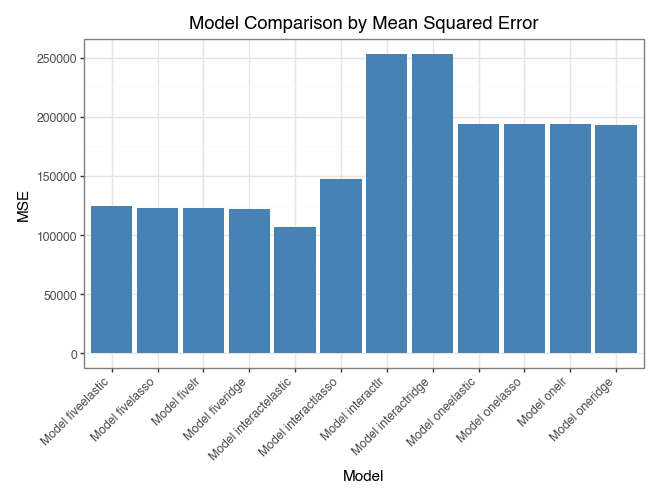

In [ ]:
from plotnine import ggplot, aes, geom_bar, labs, theme_bw, theme, element_text

(
    ggplot(mse_df, aes(x="Model", y="MSE")) +
    geom_bar(stat="identity", fill="steelblue") +
    labs(
        title="Model Comparison by Mean Squared Error",
        x="Model",
        y="MSE"
    ) +
    theme_bw() +
    theme(
        axis_text_x=element_text(angle=45, ha='right')  
    )
)


This plot shows that the interact elastic model has the lowest MSE of all of the other plots. This reinforces the idea that this is the best model. In order to make salary predictions, this model can be used. 